In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# General Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Scikit-Learn Libraries
from sklearn.metrics import log_loss,mean_squared_error
from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split,learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model,svm,tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Keras Libraries 
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,load_model
from keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from keras.utils import to_categorical

# Interactive Widgets
from ipywidgets import interact
from IPython.display import display

In [12]:
def createCustomSplit(testSize=0.2):
    trainDF = pd.read_csv("./data/titanic/titanicFull.csv")
    trainDF = trainDF.sample(frac=1)
    testDelim = int(testSize*trainDF.shape[0])
    test_custom = trainDF[:testDelim]
    train_custom = trainDF[testDelim:]

    train_custom.to_csv("train_custom.csv",index = False)
    test_custom.to_csv("test_custom.csv",index = False)

def loadCustomSplit():
    return pd.read_csv("train_custom.csv"),pd.read_csv("test_custom.csv")

#createCustomSplit()
train,test = loadCustomSplit()

In [14]:
# Our prepprocessing function which is applied to every row of the target dataframe. 
def preprocessRow(row):
    # Process Categorical Variables - One-Hot-Encoding
    sex      = [0,0]
    embarked = [0,0,0]
    pclass   = [0,0,0]
    
    if row["Sex"] == "male":
        sex = [0,1]
    elif row["Sex"] == "female":
        sex = [1,0]
    
    if row["Embarked"] == "S":
        embarked = [0,0,1]
    elif row["Embarked"] == "C":
        embarked = [0,1,0]
    elif row["Embarked"] == "Q":
        embarked = [1,0,0]
    
    if row["Pclass"] == 1:
        pclass   = [0,0,1]
    elif row["Pclass"] == 2:
        pclass   = [0,1,0]
    elif row["Pclass"] == 3:
        pclass   = [1,0,0]
 
    return pclass+sex+[row["Age"],row["Sibsp"],row["Parch"],row["Fare"]]+embarked

# Labels for the feature columns. 
featureLabels = ["3 Class","2 Class","1 Class","Female","Male","Age","Sibsp",
                 "Parch","Fare","Q Embarked","C Embarked","S Embarked"]

# Fill Missing Values
trainDF = train.fillna(0)
testDF = test.fillna(0)

# Preprocess Data
trainPre = np.stack(trainDF.apply(preprocessRow,axis=1).values)
testPre = np.stack(testDF.apply(preprocessRow,axis=1).values)
 
def meanBaseline(df):
    nRows = df["Survived"].shape[0]
    mean = df["Survived"].sum()/nRows
    return log_loss(df["Survived"],np.full(nRows,mean))

def genderBaseline(df):
    nRows = df["Survived"].shape[0]
    pred = df["Sex"].map(lambda x: 1 if x == "female" else 0)
    res = df["Survived"]==pred
    return res.sum()/res.count()

print("Mean Baseline: {0}".format(meanBaseline(trainDF)))
print("Gender Baseline: {0}".format(genderBaseline(trainDF)))

Mean Baseline: 0.6648802865608855
Gender Baseline: 0.7843511450381679


In [16]:
X_train, y_train = [trainPre, to_categorical(trainDF["Survived"].values,2)]
X_test, y_test   = [testPre, to_categorical(testDF["Survived"].values,2)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
__________

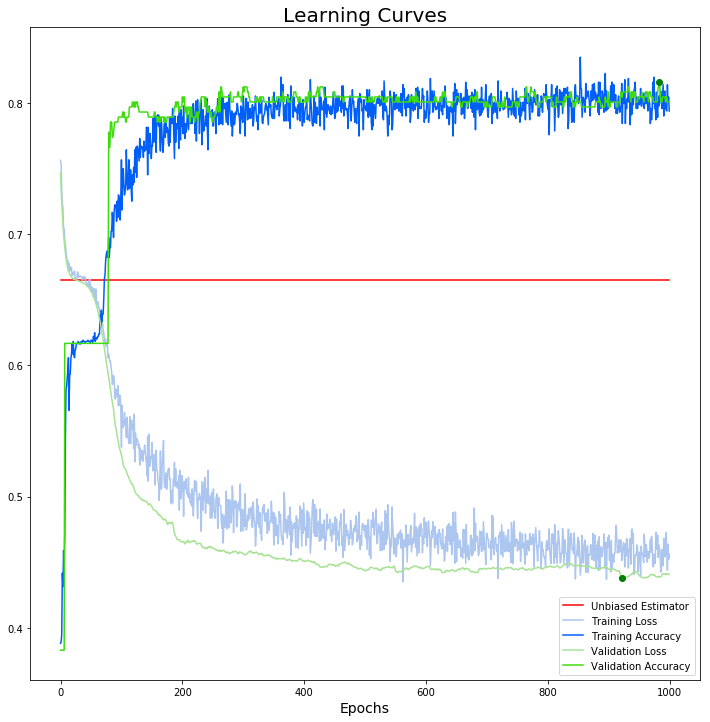

Max validation accuracy: 0.8160919704656492
Minimum validation loss: 0.43812912942349225


In [17]:
# Training Hyperparameters
batch_size = 100
epochs = 1000

# Regularization 
lossFn = 'categorical_crossentropy'
optimizer = 'adam'
activationFn = 'softmax'

# Model Arch
inputs = Input(shape=(X_train.shape[1],),name="input")
normedInputs = BatchNormalization()(inputs)
x = Dropout(0.1)(normedInputs)
x = Dense(40, activation=activationFn)(x)
x = Dropout(0.12)(x)
x = Dense(20, activation=activationFn)(x)
x = Dropout(0.14)(x)
x = Dense(10, activation=activationFn)(x)
x = Dropout(0.18)(x)
x = Dense(5, activation=activationFn)(x)
x = Dropout(0.2)(x)
out = Dense(2,activation=activationFn, name="output")(x)

modelMain = Model(inputs=inputs, outputs=out)
modelMain.compile(optimizer=optimizer,loss=lossFn,metrics=['acc'])
    

# We create a callback that saves the best model in respect to maximizing validation accuracy.
checkpoint =  ModelCheckpoint(monitor='val_acc',filepath='bestModel.hdf5', verbose=0, save_best_only=True)

modelMain.summary()

hist = modelMain.fit(X_train, y_train,validation_data=(X_test, y_test), 
                     batch_size=batch_size,epochs=epochs, verbose=0,callbacks=[checkpoint])

def learningCurves(hist):
    histAcc_train = hist.history['acc']
    histLoss_train = hist.history['loss']
    histAcc_validation = hist.history['val_acc']
    histLoss_validation = hist.history['val_loss']
    maxValAcc = np.max(histAcc_validation)
    minValLoss = np.min(histLoss_validation)

    plt.figure(figsize=(12,12))

    plt.plot(range(epochs),np.full(epochs,meanBaseline(trainDF)),label="Unbiased Estimator", color="red")

    plt.plot(range(epochs),histLoss_train, label="Training Loss", color="#acc6ef")
    plt.plot(range(epochs),histAcc_train, label="Training Accuracy", color = "#005ff9" )

    plt.plot(range(epochs),histLoss_validation, label="Validation Loss", color="#a7e295")
    plt.plot(range(epochs),histAcc_validation, label="Validation Accuracy",color="#3ddd0d")

    plt.scatter(np.argmax(histAcc_validation),maxValAcc,zorder=10,color="green")
    plt.scatter(np.argmin(histLoss_validation),minValLoss,zorder=10,color="green")

    plt.xlabel('Epochs',fontsize=14)
    plt.title("Learning Curves",fontsize=20)

    plt.legend()
    plt.show()

    print("Max validation accuracy: {0}".format(maxValAcc))
    print("Minimum validation loss: {0}".format(minValLoss))

learningCurves(hist)

In [20]:
#model = load_model("bestModel.hdf5")
pred = modelMain.predict(X_test)

neuralOutput = pd.DataFrame.from_items([
    ('Died_Prob',pred[:,0]),
    ('Survived_Prob',pred[:,1]),
    ('True_Label',testDF["Survived"])])

neuralOutput.to_csv('neural_out_test.csv', index = True)

In [22]:
pred = modelMain.predict(X_train)

neuralOutput = pd.DataFrame.from_items([
    ('Died_Prob',pred[:,0]),
    ('Survived_Prob',pred[:,1]),
    ('True_Label',trainDF["Survived"])])

neuralOutput.to_csv('neural_out_train.csv', index = True)

In [128]:
compDF = pd.read_csv("./data/titanic/test.csv")
compDF = compDF.fillna(0)
pred = modelMain.predict(np.stack(compDF.apply(preprocessRow,axis=1).values))

data_to_submit = pd.DataFrame.from_items([
    ('PassengerId',compDF["PassengerId"]),
    ('Survived', pd.Series(np.argmax(pred,axis=1)))])

data_to_submit.to_csv('submit.csv', index = False)